In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import patient_id_age, heart_rate, create_index,urine,blood_pressure, lab_result, pao2fio2

# os.chdir('D:/JHU/BDD/ICU streaming data/eicu-collaborative-research-database-demo-2.0.1/demo') 
os.chdir('/Users/xiao-zy19/Desktop/Johns Hopkins/Biomedical Data Design/EICU Database/eicu-collaborative-research-database-demo-2.0.1') 

# TODO 
# 1 add split for multiple compute nodes 应当直接在外部split，然后再传入
# 2 exclude "too sparse" data
# 3 save file
# 4 add more gaussian args into input of function

In [2]:
def align_data(patient_batch, patient_offset, data, kernel='C(1.0) * RBF(10) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e5))'):
    """
    Summary: align data and interpolate missing values
    
    Args:
        patient_batch: the list of wanted patient id, used to split data
        patient_offset: the dataframe of patient offset data, including patientunitstayid, unitdischargeoffset
        data: the dataframe of data, including patientunitstayid, observationoffset, value
        kernel: the self-defined kernel function for Gaussian Process Regressor

    Returns:
        data_full: the dataframe of aligned and interpolated data, including patientunitstayid, observationoffset, value
        data_full_index: the series of the index of the first occurrence of each patient
    """
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
    
    # turn kernel string to kernel function
    kernel = eval(kernel)
    
    column_names = data.columns.tolist()
    print(column_names)
    
    # data = data[data['patientunitstayid'].isin(patient_batch)]
    # patient_offset = patient_offset[patient_offset['patientunitstayid'].isin(patient_batch)]
    data = data[data[column_names[0]].isin(patient_batch)]
    patient_offset = patient_offset[patient_offset[column_names[0]].isin(patient_batch)]
    
    # transform patient_offset to hours
    patient_hours = patient_offset.copy().reset_index(drop=True)
    patient_hours['unitdischargeoffset'] = np.floor(patient_hours['unitdischargeoffset']/60).astype(int)
    
    # get unique patient ids in data
    unique_data_patient_ids = data['patientunitstayid'].unique()
    patient_hours = patient_hours[patient_hours['patientunitstayid'].isin(unique_data_patient_ids)].reset_index(drop=True)
    
    # get unique patient ids in patient_id
    data_hour_buf = data.copy().reset_index(drop=True)
    # data_hour_buf["observationoffset"] = np.floor(data_hour_buf["observationoffset"]/60).astype(int)
    data_hour_buf[column_names[1]] = np.floor(data_hour_buf[column_names[1]]/60).astype(int)
    data_hour_buf = data_hour_buf.groupby([column_names[0], column_names[1]], as_index=False)[column_names[2]].mean()
    data_hour_buf.sort_values(by=[column_names[0], column_names[1]], inplace=True)
    
    data_hour_cleaned = pd.merge(data_hour_buf, patient_hours, on=column_names[0], how='left')
    data_hour_cleaned = data_hour_cleaned[data_hour_cleaned[column_names[1]] <= data_hour_cleaned['unitdischargeoffset']]
    data_hour = data_hour_cleaned.drop(['unitdischargeoffset'], axis=1)
    
    max_offset_per_patient = data_hour.groupby(column_names[0]).max().reset_index()
    
    complete_ranges = []
    for index, row in max_offset_per_patient.iterrows():
        patient_id = row[column_names[0]]
        max_offset = row[column_names[1]]
        complete_range = pd.DataFrame({
            column_names[0]: patient_id,
            column_names[1]: range(int(max_offset)+1)
        })
        complete_ranges.append(complete_range)
    
    complete_ranges = pd.concat(complete_ranges, ignore_index=True)
    data_full = pd.merge(complete_ranges, data_hour, on=[column_names[0], column_names[1]], how='left')
    data_full_index = create_index(data_full)
    # print(data_full_index)
    
    for i in range(len(data_full_index)-1):
        if data_full.iloc[data_full_index[i]:data_full_index[i+1]].isnull().values.any(): # test: and i<50
            data_data = data_full.iloc[data_full_index[i]:data_full_index[i+1]][[column_names[1], column_names[2]]].to_numpy()
            data_id = data_full.iloc[data_full_index[i]:data_full_index[i+1]][column_names[0]].unique()[0]
            
            t = data_data[:, 0].astype('float64')
            y = data_data[:, 1].astype('float64')
            t_known = t[~np.isnan(y)]
            y_known = y[~np.isnan(y)]
            t_missing = t[np.isnan(y)]
            if(len(t_known)) < 1:
                continue
            
            # kernel (default)
            # kernel = C(1.0) * RBF(10) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e5))
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1000, normalize_y=True)
            gp.fit(t_known.reshape(-1, 1), y_known) #fit
            y_pred, sigma = gp.predict(t_missing.reshape(-1, 1), return_std=True)    
            inter_data = pd.DataFrame({
                column_names[0]: data_id,
                column_names[1]: t_missing,
                column_names[2]: y_pred
            })
            for idx, row in inter_data.iterrows():
                mask = (data_full[column_names[0]] == row[column_names[0]]) & (data_full[column_names[1]] == row[column_names[1]]) & data_full[column_names[2]].isnull()
                data_full.loc[mask, column_names[2]] = row[column_names[2]]
            y_pred_all = gp.predict(t.reshape(-1, 1))
            print(f'finished {i}th patient, patient_id: {data_id}')
            plt.scatter(t_known, y_known, color='red', label='Known data')
            plt.scatter(t_missing, y_pred, color='blue', label='Interpolated data')
            plt.plot(t, y_pred_all)
            plt.fill_between(t_missing, y_pred - sigma, y_pred + sigma, alpha=0.2, color='blue')
            plt.title(f'Interpolation for Patient {data_id}')
            plt.xlabel('Time Offset')
            plt.ylabel(column_names[2])
            plt.legend()
            plt.show()
            
    return None

In [3]:
# get patient id
patient_id, patient_age, patient_offset = patient_id_age()

# split patient id into batches
batch_size = 8
patient_batch = [patient_id[i:i + batch_size] for i in range(0, len(patient_id), batch_size)]

print(patient_batch[5])

[230150 230427 234941 242895 243097 243999 244477 249328]


In [4]:
# extract heart rate data
# _,_,BP,_,_,_,_,_ = blood_pressure(patient_batch[5])
BUN,_,WBC,_,_,_,_,_,_,_,_,_ = lab_result(patient_batch[5])
print(BUN.head(5))
f_FIO2, fio2_index, lab_paO2, pao2_index = pao2fio2(patient_batch[5])
print(f_FIO2.head(5))
print(lab_paO2.head(5))

Loading lab Data...
lab_result Data Loaded. Time: 0.27s
        patientunitstayid  observationoffset   BUN
403069             230150              -2046  26.0
403084             230150              -1406  52.0
403131             230150                  5  59.0
219696             230427                 46  21.0
219551             230427                733  18.0
Loading pao2/fio2 Data...
pao2/fio2 Data Loaded. Time: 1.14s
    patientunitstayid  observationoffset   FiO2
15           230427.0             3828.0  100.0
16           230427.0             3983.0  100.0
0            230427.0             4118.0  100.0
1            230427.0             4238.0   40.0
2            230427.0             4322.0   40.0
        patientunitstayid  observationoffset   paO2
219654           230427.0             3828.0  235.0
219446           230427.0             3948.0  116.0
219758           230427.0             3983.0  321.0
219624           230427.0             4009.0  331.0
219740           230427.0    

['patientunitstayid', 'observationoffset', 'BUN']
finished 1th patient, patient_id: 230427.0


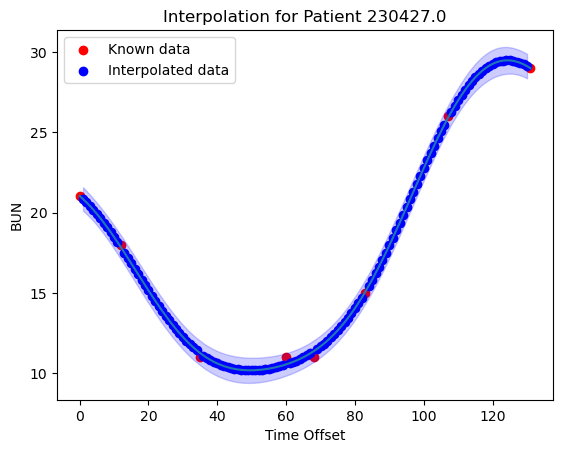

finished 2th patient, patient_id: 234941.0


c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


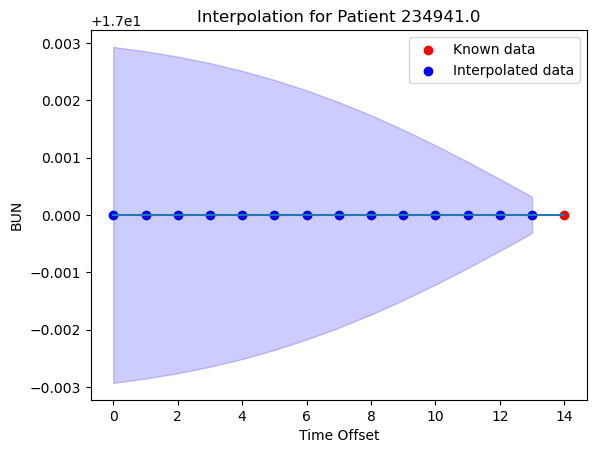

finished 3th patient, patient_id: 243097.0


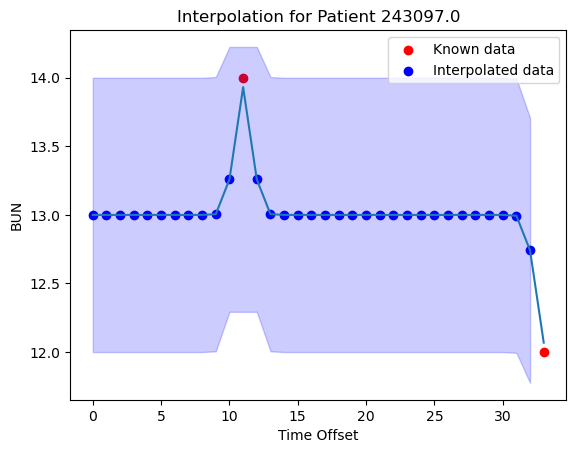

finished 4th patient, patient_id: 243999.0


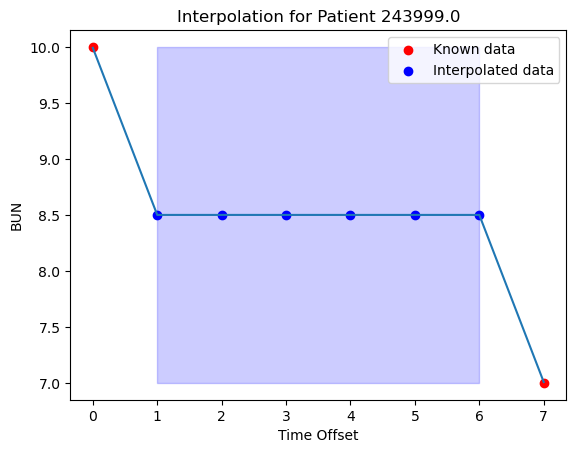

finished 5th patient, patient_id: 244477.0


c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


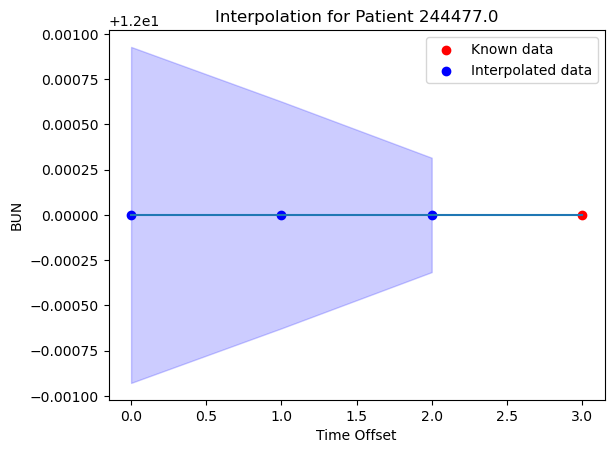

finished 6th patient, patient_id: 249328.0


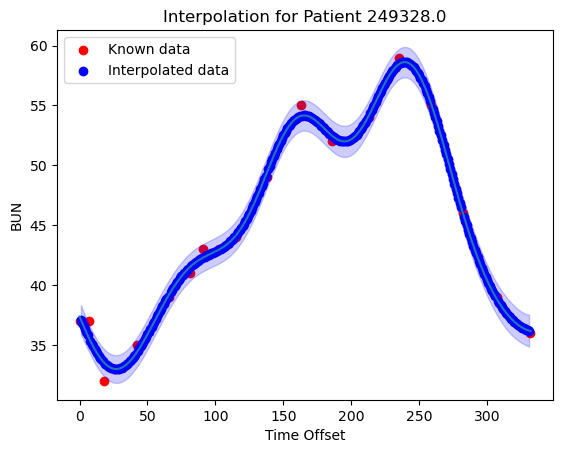

In [5]:
align_data(patient_batch[5], patient_offset, BUN)

['patientunitstayid', 'observationoffset', 'WBC x 1000']
finished 1th patient, patient_id: 230427.0


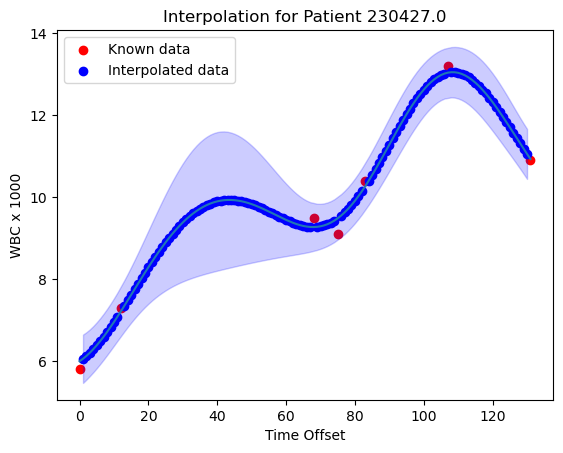

finished 2th patient, patient_id: 234941.0


c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


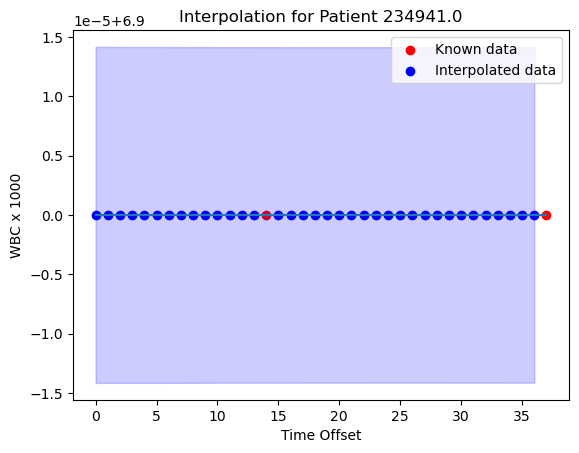

finished 3th patient, patient_id: 243097.0


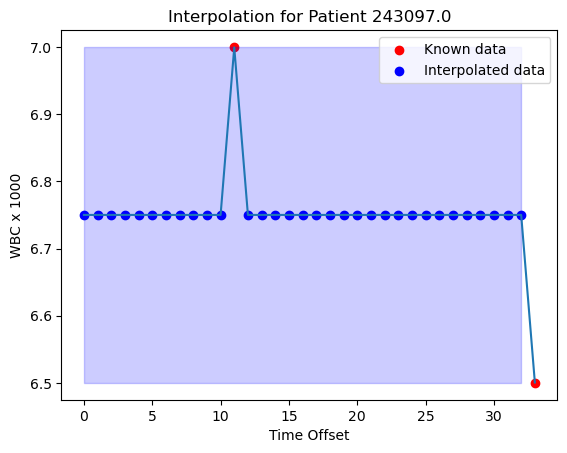

finished 4th patient, patient_id: 243999.0


c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


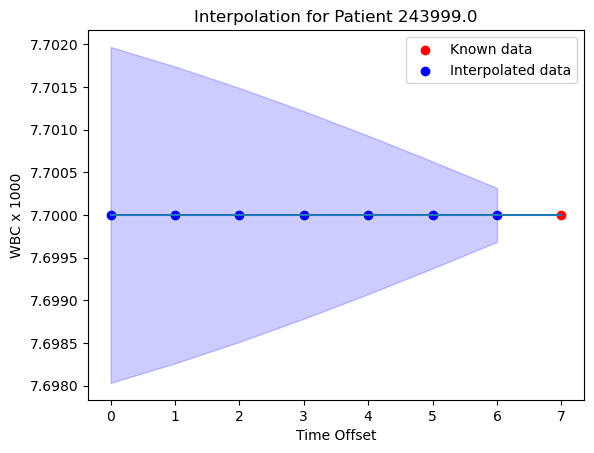

finished 5th patient, patient_id: 249328.0


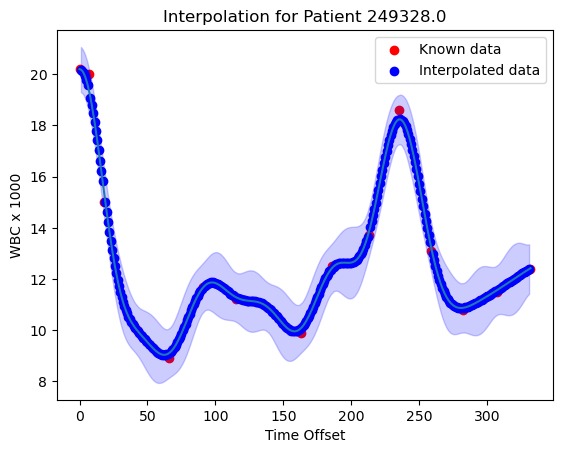

In [6]:
align_data(patient_batch[5], patient_offset, WBC)

['patientunitstayid', 'observationoffset', 'FiO2']
finished 0th patient, patient_id: 230427.0


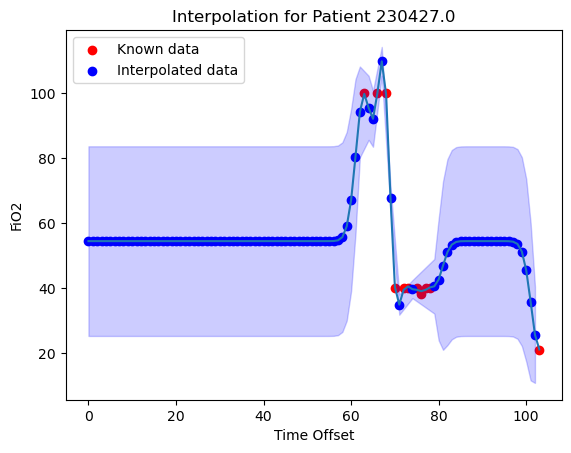

finished 1th patient, patient_id: 243097.0


c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


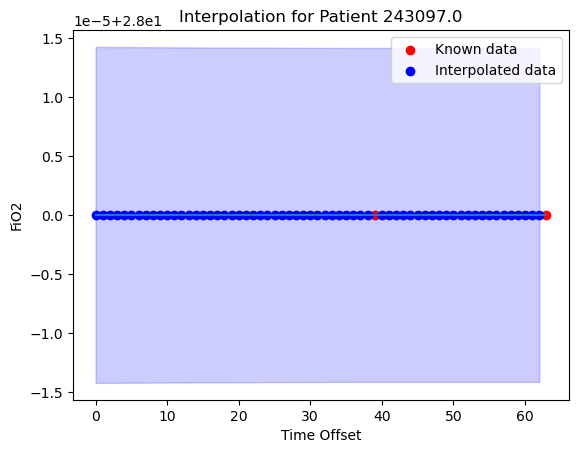

finished 2th patient, patient_id: 243999.0


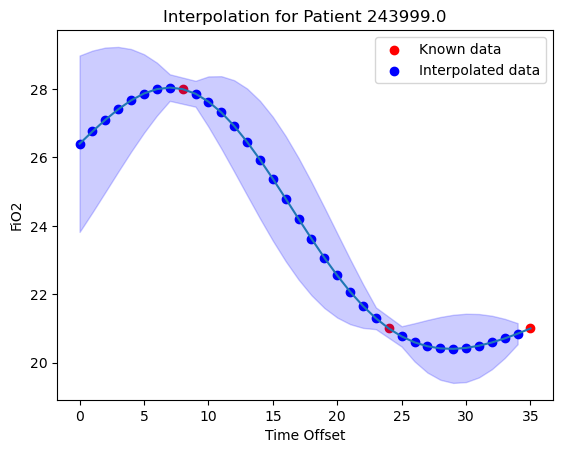

finished 3th patient, patient_id: 244477.0


c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


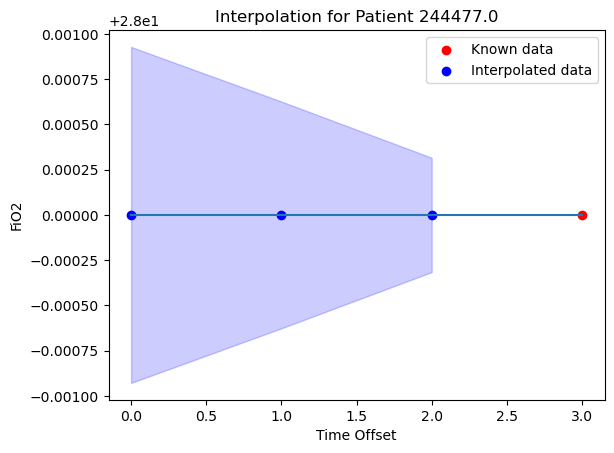

finished 4th patient, patient_id: 249328.0


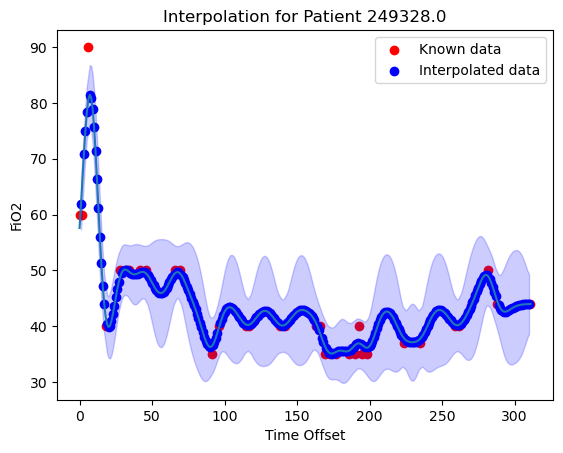

In [7]:
align_data(patient_batch[5], patient_offset, f_FIO2)

['patientunitstayid', 'observationoffset', 'paO2']
finished 0th patient, patient_id: 230427.0


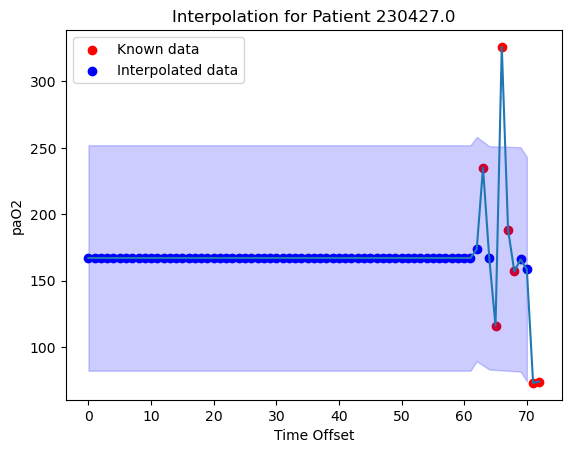

finished 1th patient, patient_id: 243097.0


c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bdd\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


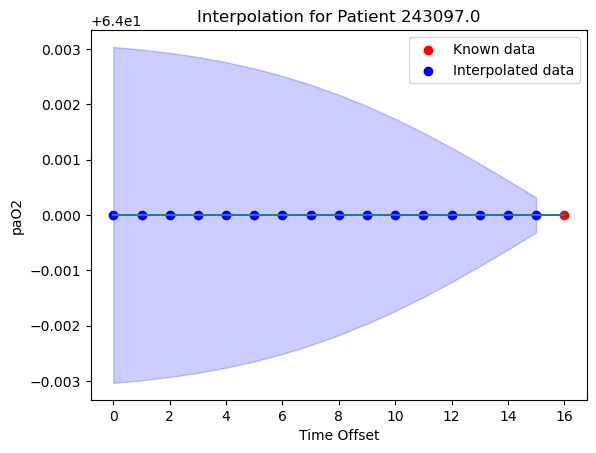

finished 2th patient, patient_id: 249328.0


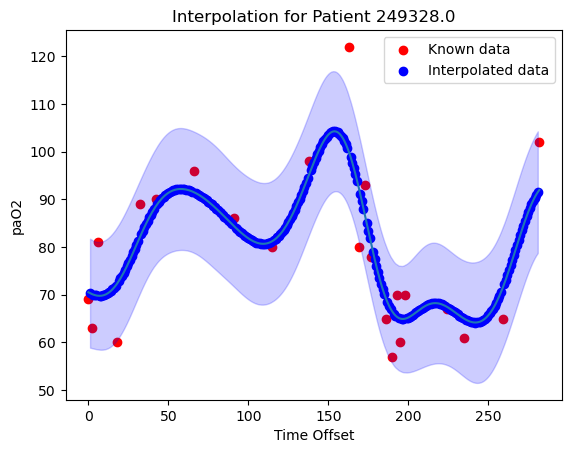

In [8]:
align_data(patient_batch[5], patient_offset, lab_paO2)